# This notebook provides a slider to compare different physics parameters

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
import numpy as np
import pandas as pd

import seaborn as sns

from scipy.interpolate import griddata

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets

from parameters_dict import physics_parameters
from dark_nus_utils import load_datasets
from plot_utils import kde_variable_plot

from const import alphaQED

In [3]:
from matplotlib import rc, rcParams
## Plot the parameter space
fsize = 12
rcParams['text.usetex'] = False
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman', 'serif']
rcParams['figure.figsize'] = (1.2*3.7,1.2*2.3617)
# rcParams['lines.linewidth'] = 1.0
rcParams['hatch.linewidth'] = 0.3
# rcParams['axes.linewidth'] = 0.4
rcParams['axes.labelsize'] = fsize
# rcParams['xtick.direction'] = 'in'
# rcParams['xtick.major.width'] = 0.4
# rcParams['xtick.minor.width'] = 0.4
rcParams['xtick.labelsize'] = fsize
# rcParams['ytick.direction'] = 'in'
# rcParams['ytick.major.width'] = 0.4
# rcParams['ytick.minor.width'] = 0.4
rcParams['ytick.labelsize'] = fsize
rcParams['legend.frameon'] = False
rcParams['legend.fontsize'] = 0.8*fsize
rcParams['legend.loc'] = 'lower right'
rcParams["text.latex.preamble"] = r'''
    \usepackage{amsmath,amssymb,amsthm}
    \usepackage{siunitx}
'''

In [4]:
hierarchy = 'heavy'
D_or_M = 'majorana'
save_folder = (f'../fig/4_analysis_variables_plots/{hierarchy}_{D_or_M}/')
!mkdir -p $save_folder

## Use this to load the datasets in the usual way and dump them in pickle files

In [5]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=False,
                                dump=True,
                                load_grid=False)

heavy majorana FHC
Wall time: 9.385440826416016 s, CPU time: 0.9943890130000002
heavy majorana RHC
Wall time: 9.005129098892212 s, CPU time: 0.9223623700000001


## Use the function this way to load the datasets from the pickle files

In [5]:
my_exp_analyses = load_datasets(hierarchy, D_or_M, 
                                timeit=True, 
                                direct_load_objects=True,
                                load_grid=False)

heavy majorana FHC
Wall time: 9.165860414505005 s, CPU time: 1.056483005
heavy majorana RHC
Wall time: 8.895034074783325 s, CPU time: 0.979888936


## Study the simulation of the geometry

In [7]:
ctaus = [0.1, 1, 10, 100]

0.1


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


1
10
100
0.1


KeyError: 'decay_point_0.1_x'

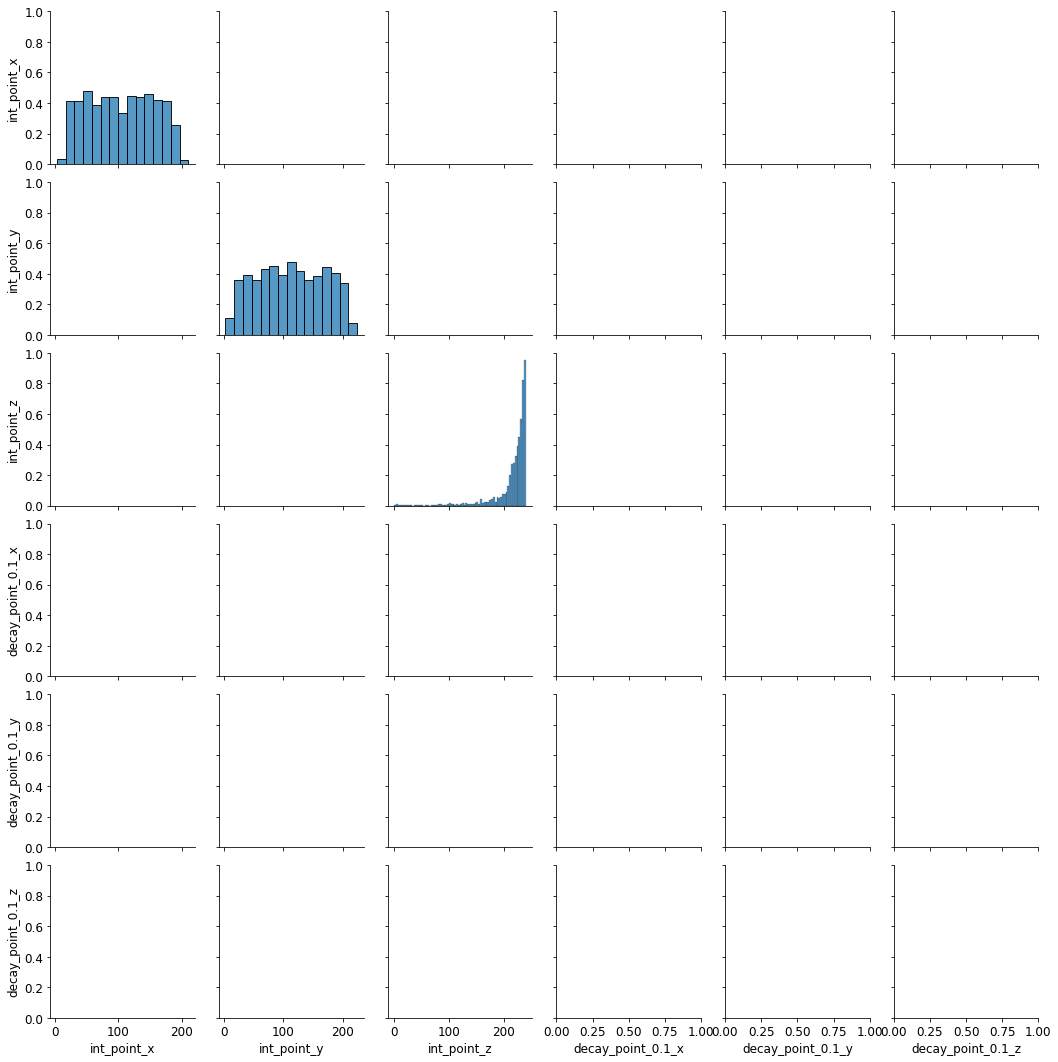

In [9]:
for key, exp_analysis in my_exp_analyses.items():
    exp_analysis.decay_in_tpc(exp_analysis.df_base, ctaus)
    for ctau in ctaus:
        print(ctau)
        sns.pairplot(exp_analysis.df_base.query(f'decay_in_tpc_{ctau}'.replace('.', '')).sample(2000), 
                     vars=['int_point_x', 'int_point_y', 'int_point_z',
                               f'decay_point_{ctau}_x', f'decay_point_{ctau}_y', f'decay_point_{ctau}_z',],)
#                      hue='material')
        plt.suptitle(key.replace('_', ' ') + f'$c\tau$ = {ctau} cm')
        plt.savefig(save_folder + f'geometry_2d_plot_ctau_{ctau}_{key}'.replace('.', '')+'.pdf', bbox_inches='tight')
        plt.close()

## Study N events vs ctau

In [10]:
from ctau_utils import ctau_heavy
BP = {'m4': 0.12, 'mz': 1.25}

In [11]:
epsilons = np.geomspace(5e-5, 1e-1, 50)
Ud4_2s = [1, 1e-2, 1e-4]

In [12]:
exp_analysis = my_exp_analyses[hierarchy + '_' + D_or_M + '_FHC']

In [13]:
exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']))

(9923.296989790155, 20458.354586056925)

In [14]:
ctau = ctau_heavy(BP['m4'], BP['mz'], 0.01 * exp_analysis.alpha_dark * alphaQED * exp_analysis.epsilon2, D_or_M)
exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']), ctau=ctau)

(1120.931732224157, 2569.9975880555594)

In [15]:
# compute nevents
n_events_base = []
for epsilon in epsilons:
    n_events_base.append(exp_analysis.kde_n_events(exp_analysis.df_base, 
                                                   (BP['m4'], BP['mz']), 
                                                   mu=epsilon**2/exp_analysis.epsilon2)[0])
n_events_decay = {}
ctaus_ud4 = {}
for Ud4_2 in Ud4_2s: 
    n_events_decay[Ud4_2] = []
    ctaus_ud4[Ud4_2] = []
    for epsilon in epsilons:
        Valpha4_alphaepsilon2 = Ud4_2 * exp_analysis.alpha_dark * alphaQED * epsilon**2
        ctau = ctau_heavy(BP['m4'], BP['mz'], Valpha4_alphaepsilon2, D_or_M)
        ctaus_ud4[Ud4_2].append(ctau)
        n_events_decay[Ud4_2].append(exp_analysis.kde_n_events(exp_analysis.df_base, 
                                                   (BP['m4'], BP['mz']), 
                                                   ctau=ctau,
                                                   mu=epsilon**2/exp_analysis.epsilon2)[0])

In [16]:
# compute efficiency vs ctau
ctaus = np.geomspace(1e-3, 1e8, 50)
eff_vs_ctau = []
n_events_no_geom = exp_analysis.kde_n_events(exp_analysis.df_base, (BP['m4'], BP['mz']))[0]
for ctau in ctaus:
    eff_vs_ctau.append(exp_analysis.kde_n_events(exp_analysis.df_base,
                                                   (BP['m4'], BP['mz']),
                                                   ctau=ctau)[0]/n_events_no_geom)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


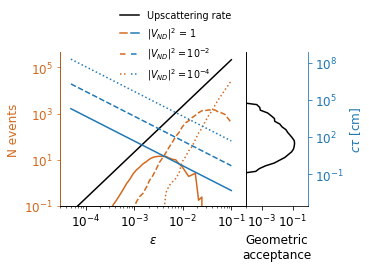

In [17]:
color_ctau = 'C0'
color_rate = 'chocolate'
fig, ax = plt.subplots(ncols=2,
                       nrows=1,
#                        figsize=(4.44, 3.2),
                       sharey='none',
                       gridspec_kw={'width_ratios':[3, 1]})

up_scattering_rate_line, = ax[0].plot(epsilons, n_events_base, label='Upscattering rate', color='black')
ax2 = ax[0].twinx()
ax[1].get_shared_y_axes().join(ax[1], ax2)
fig.subplots_adjust(wspace=0)

ax[0].loglog()  
ax[0].set_ylim(bottom=0.1)
ax[0].set_xlim(3e-5, 2e-1)

ax[0].set_xlabel('$\epsilon$')
ax[0].set_ylabel('N events', color=color_rate)
ax[0].tick_params(axis='y', colors=color_rate, which='both')
ax2.spines['left'].set_color(color_rate) 

ax[1].loglog()
ax[1].set_xlim(9e-5, 1)
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.spines['top'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].yaxis.tick_right()
ax[1].tick_params(axis='y', colors=color_ctau)
ax[1].yaxis.set_label_position("right")
ax[1].spines['right'].set_color(color_ctau)  
ax[1].set_ylabel(r'$c \tau$ [cm]', color=color_ctau)
ax[1].set_xticks([1e-3, 1e-1])
ax[1].set_xlabel('Geometric\nacceptance')
ax[1].spines['top'].set_visible(False)

linestyles = ['-', '--', 'dotted', '-.']
rate_lines = {}
ctau_lines = {}
for Ud4_2, linestyle in zip(Ud4_2s, linestyles): 
    rate_lines[Ud4_2], = ax[0].plot(epsilons, n_events_decay[Ud4_2], 
                      color=color_rate, linestyle=linestyle)
    ctau_lines[Ud4_2], = ax2.plot(epsilons, ctaus_ud4[Ud4_2], '--', color=color_ctau, linestyle=linestyle)
    
ax[0].legend([up_scattering_rate_line] + list(zip(rate_lines.values(), ctau_lines.values())),
             ['Upscattering rate'] + [f'$|V_{{ND}}|^2$ = {Ud4_2}' if Ud4_2==1 else r'$|V_{{ND}}|^2 = 10^{'+f'{np.log10(Ud4_2):.1g}'+r'}$'
              for Ud4_2 in Ud4_2s],
             frameon=False, loc=(0.3, 0.78), 
             numpoints=1,
             handler_map={tuple: HandlerTuple(ndivide=None)})

ax[1].plot(eff_vs_ctau, ctaus, color='black')
plt.savefig(save_folder + 'n_events_vs_ctau.pdf', bbox_inches='tight', transparent=True)
plt.savefig(save_folder + 'n_events_vs_ctau.png', dpi=250, bbox_inches='tight', transparent=True)

# Number of events vs c$\tau$ and $V_{ND}$ on the same axis

In [6]:
from posteriors import heavy_nonminimal_posterior_v

In [20]:
my_exp_analyses['heavy_majorana_FHC'].kde_n_events(df=my_exp_analyses['heavy_majorana_FHC'].df_base,
                             selection_query='cut_based & lead',
                             m4mz=(0.1, 1.25),
                             ctau=None,
                             mu=1/14,
                             provide_n_samples=True,
                             ctau_mode='integral')[0] +\
my_exp_analyses['heavy_majorana_RHC'].kde_n_events(df=my_exp_analyses['heavy_majorana_RHC'].df_base,
                             selection_query='cut_based & lead',
                             m4mz=(0.1, 1.25),
                             ctau=None,
                             mu=1/14,
                             provide_n_samples=True,
                             ctau_mode='integral')[0]

215.56084354031404

In [ ]:
heavy_nonminimal_posterior_v(my_exp_analyses, ctau_mode='integral',
                             ctau=)

In [20]:
V_ND_2_s = np.geomspace(2.2e-7, 1, 10)

out = heavy_nonminimal_posterior_v(my_exp_analyses, Ud4_2=V_ND_2_s, ctau_mode='integral')

Text(0.5, 0, '$c\\tau$ [cm]')

<ipython-input-21-95bc7954fcbc>:21: RuntimeWarning: divide by zero encountered in log
  return np.exp(backward_fun(np.log(x)))


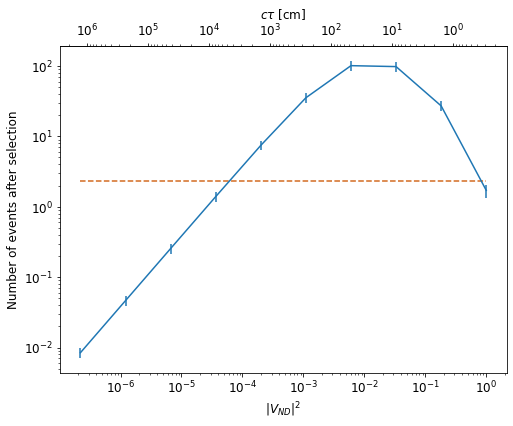

In [21]:
from scipy.interpolate import UnivariateSpline

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')
ax.errorbar(V_ND_2_s, out[1], yerr=np.sqrt(out[2]))
ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')

ax.set_yscale('log')
ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

forward_fun = UnivariateSpline(np.log(V_ND_2_s), np.log(out[3]), k=1)

backward_fun = UnivariateSpline(np.log(out[3][::-1]), np.log(V_ND_2_s[::-1]), k=1)

def forward(x):
    return np.exp(forward_fun(np.log(x)))

def backward(x):
    return np.exp(backward_fun(np.log(x)))

secax = ax.secondary_xaxis('top', functions=(forward, backward))
secax.set_xlabel('$c\\tau$ [cm]')

# Number of events for different BPs as a function of $V_{ND}$ or c$\tau$

In [22]:
from posteriors import heavy_nonminimal_posterior_v

In [23]:
bps = [{'mz': 1.25, 'epsilon': 2.1e-2},
       {'mz': 1.25*0.5, 'epsilon': 2.1e-2*0.5},
       {'mz': 1.25*0.1, 'epsilon': 2.1e-2*0.1}]

In [24]:
V_ND_2_s = np.geomspace(2.2e-7, 1, 10)

out = []
for bp in bps:
    out.append(heavy_nonminimal_posterior_v(my_exp_analyses, Ud4_2=V_ND_2_s, ctau_mode='integral', **bp))

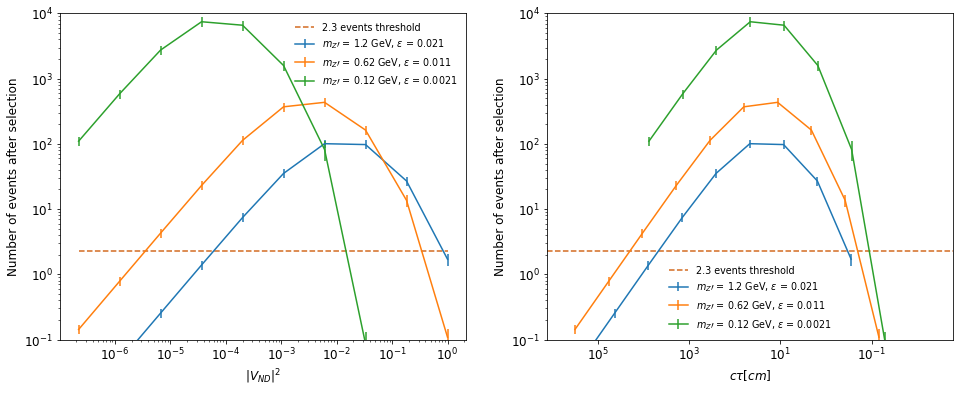

In [25]:
from scipy.interpolate import InterpolatedUnivariateSpline

test_points = np.geomspace(1e-5, 1, 30)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

ax = axs[0]
ax.set_xlabel('$|V_{ND}|^2$')
for bp, aux_out in zip(bps, out):
    ax.errorbar(V_ND_2_s, aux_out[1], yerr=np.sqrt(aux_out[2]),
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')
    
ax = axs[1]
ax.set_xlabel('$c \\tau [cm]$')
for bp, aux_out in zip(bps, out):
    ax.errorbar(aux_out[3], aux_out[1], yerr=np.sqrt(aux_out[2]),
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
ax.hlines(2.3, out[0][3][0], out[-1][3][-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')
ax.set_xlim(out[0][3][0], out[-1][3][-1])
    
for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Number of events after selection')
    ax.set_ylim(0.1, 1e4)
    ax.legend(frameon=False, loc='best')

<ipython-input-65-0cf5d53b8319>:18: RuntimeWarning: divide by zero encountered in log
  ax.errorbar(np.log(V_ND_2_s)[mask], np.log(aux_out[1])[mask],
<ipython-input-65-0cf5d53b8319>:19: RuntimeWarning: divide by zero encountered in log
  yerr=np.log(np.sqrt(aux_out[2]))[mask], fmt=f'C{i} .',
<ipython-input-65-0cf5d53b8319>:23: RuntimeWarning: divide by zero encountered in log
  np.log(aux_out[1])[mask])(np.log(test_points)), f'C{i}')


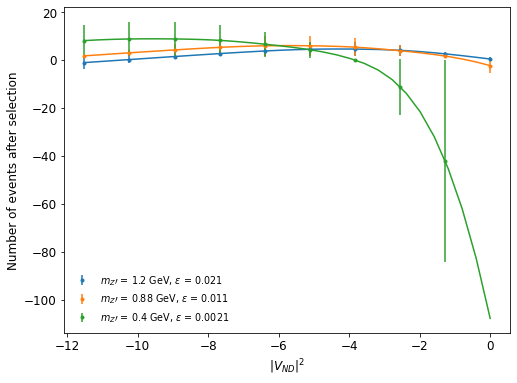

In [65]:
from scipy.interpolate import InterpolatedUnivariateSpline

test_points = np.geomspace(1e-5, 1, 30)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')

for i, (bp, aux_out) in enumerate(zip(bps, out)):
    mask = aux_out[1] != 0
    ax.errorbar(np.log(V_ND_2_s)[mask], np.log(aux_out[1])[mask], 
                yerr=np.log(np.sqrt(aux_out[2]))[mask], fmt=f'C{i} .',
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")
    ax.plot(np.log(test_points), 
            InterpolatedUnivariateSpline(np.log(V_ND_2_s)[mask], 
                                         np.log(aux_out[1])[mask])(np.log(test_points)), f'C{i}')
ax.legend(frameon=False, loc='best')
# ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

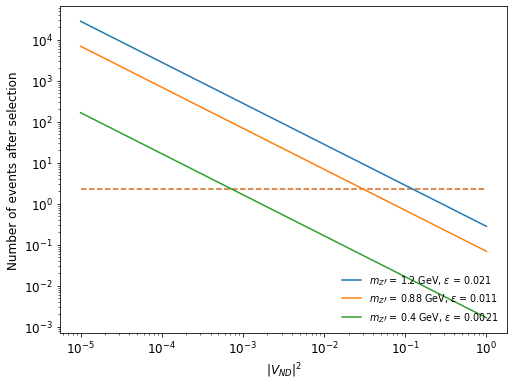

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_xscale('log')

ax.set_xlabel('$|V_{ND}|^2$')
ax.set_ylabel('Number of events after selection')

ax.set_yscale('log')

for bp, aux_out in zip(bps, out):
    ax.errorbar(V_ND_2_s, aux_out[3], 
                label=f"$m_Z\prime$ = {bp['mz']:.2g} GeV, $\epsilon$ = {bp['epsilon']:.2g}")

ax.legend(frameon=False, loc='best')
ax.hlines(2.3, V_ND_2_s[0], V_ND_2_s[-1], colors='chocolate', linestyles='dashed', label='2.3 events threshold')

## Slider for physics distributions

In [ ]:
@interact(var=widgets.Dropdown(
                options=list(my_exp_analysis.df_base.columns.to_frame().loc[:, 0].values),
                description='Variable:',
                disabled=False,
            ),
          bins=widgets.IntSlider(min=1, max=50, step=1, value=10, continuous_update=False),
          hist_range=widgets.FloatRangeSlider(
                value=[0, 5],
                min=0,
                max=1e10,
                step=0.1,
                disabled=False,
                continuous_update=False,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
          m4=widgets.FloatSlider(min=0.005, max=1, step=0.025, value=0.3, continuous_update=False), 
          mz=widgets.FloatSlider(min=0.005, max=10, step=0.005, value=2, continuous_update=False), 
          ctau=widgets.FloatLogSlider(
                base=10,
                min=-2, # max exponent of base
                max=3, # min exponent of base
                step=0.2, # exponent step
                value=25,
            ),
          kernel=widgets.Dropdown(
                options=['epa', 'gaus'],
                description='Kernel type:',
                disabled=False,
            ),
          smooth_m4=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.03, continuous_update=False), 
          smooth_mz=widgets.FloatSlider(min=0.001, max=0.5, step=0.001, value=0.005, continuous_update=False), 
          selection_step=widgets.RadioButtons(
                options=['no_selection', 'cut_based', 'geometric', 'geometric_cut_based'],
                value='no_selection',
                description='selection:',
            ),
          df=fixed(my_exp_analysis.df_base),
         exp_analysis = fixed(my_exp_analysis))

def output_distrib(exp_analysis, df, var, bins, hist_range, m4, mz, ctau, kernel, smooth_m4, smooth_mz, selection_step):
    
    m4_values = df['m4'].values
    mz_values = df['mzprime'].values
    df_values = np.stack([m4_values, mz_values], axis=-1)
    this_kde_weights = exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])
    weight_values = this_kde_weights * df['actual_weight'].values

    if selection_step == 'no_selection':
        pass
    if 'cut_based' in selection_step:
        weight_values *= df['cut_based'].values
    if 'geometric' in selection_step:
        exp_analysis.decay_in_tpc(df, ctau)
        weight_values *= df[f'decay_in_tpc_{ctau}']

    plt.hist(df[var],
             range=hist_range,
             bins=bins,
             weights=weight_values,
             histtype='step',
             label=f'kde2D, from $m_4$ in [{m4_values.min():.2g}, {m4_values.max():.2g}], $m_Z$ in [{mz_values.min():.2g}, {mz_values.max():.2g}]\nexpected events = {weight_values.sum():.1f}')
    plt.ylim(bottom=0)
    plt.xlabel(f"{var}")
    plt.ylabel(f"Expected number of entries / {(hist_range[1]-hist_range[0])/bins:.2g}")
    plt.title(f"$m_4$ = {m4:.2g} GeV, $m_Z$ = {mz:.2g} GeV, $c\\tau$ = {ctau:.2g} cm\n$\sigma_{{m_4}}$ = {smooth_m4:.2g} GeV, $\sigma_{{m_Z}}$ = {smooth_mz:.2g} GeV\nselection step = {selection_step}, expected events = {weight_values.sum():.1f}")
    return weight_values.sum()

## Distribution of events throughout detector

In [ ]:
ctau = 20
m4 = 0.1
mz = 1.25

m4_values = my_exp_analysis.df_base['m4'].values
mz_values = my_exp_analysis.df_base['mzprime'].values
df_values = np.stack([m4_values, mz_values], axis=-1)
smooth_m4, smooth_mz = 0.005, 0.05
this_kde_weights = my_exp_analysis.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

variable_1 = ('int_point_y')
variable_2 = ('int_point_z')
selection_step = 'no_selection'
        
my_exp_analysis.decay_in_tpc(my_exp_analysis.df_base, ctau)

if selection_step not in 'no_selection':
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[selection_step].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values
else:
    weight_values = this_kde_weights *\
                my_exp_analysis.df_base['actual_weight'].values *\
                my_exp_analysis.df_base[f'decay_in_tpc_{ctau}'].values        


In [ ]:
x,y = my_exp_analysis.df_base[variable_1], my_exp_analysis.df_base[variable_2]
points = np.array([x,y]).T
grid_x, grid_y = np.mgrid[np.min(x):np.max(x):10j, np.min(y):np.max(y):20j]
grid_z0 = griddata(points, weight_values, (grid_x, grid_y), method='linear')

In [ ]:
x,y,z = my_exp_analysis.df_base['int_point_x'], my_exp_analysis.df_base['int_point_y'], my_exp_analysis.df_base['int_point_z']

In [ ]:
plt.scatter(x,z,c=weight_values)

In [ ]:
plt.imshow(grid_z0, origin='lower')

# plt.scatter(x,y,c=)

plt.legend(frameon=False)
plt.xlabel(f'{variable_1} (cm)')
plt.ylabel(f'{variable_2} (cm)')

# Event rate in the light case in the FGD

In [7]:
from parameters_dict import *

In [8]:
selection = 'carbon'
exp_analysis = my_exp_analyses['light_majorana']
m4mz = (0.1, 0.03)
smoothing_pars = [0.1, 0.1]
mu = 0.25 * 8e-9 / exp_analysis.alpha_dark / exp_analysis.Umu4
mass_ratio = 1848.6 * 1e-9 * 184**2  * 15 / mass_material[selection]

(0.0, 29.34573481968772)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


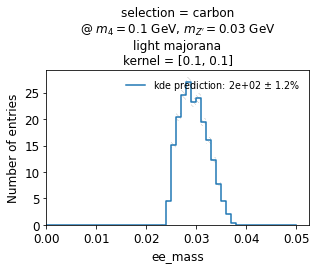

In [9]:
kde_variable_plot(var='ee_mass', 
                  range=[0, 0.05], 
                  bins=50,
                  m4mz=m4mz,
                  exp_analysis_obj=exp_analysis,
                  smoothing_pars=smoothing_pars,
                  selection_query=selection,
                  additional_scaling=mu*mass_ratio)
plt.xlim(left=0)
plt.ylim(bottom=0)

(0.0, 0.8706491813249865)

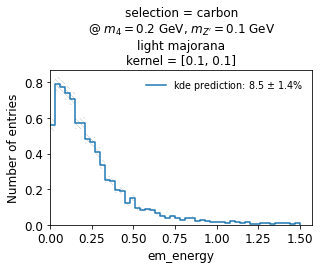

In [13]:
kde_variable_plot(var='em_energy', 
                  range=[0, 1.5], 
                  bins=50, 
                  m4mz=m4mz, 
                  exp_analysis_obj=exp_analysis, 
                  smoothing_pars=smoothing_pars, 
                  selection_query=selection,
                  additional_scaling=mu*mass_ratio)
plt.xlim(left=0)
plt.ylim(bottom=0)

(0.0, 452.89945255324636)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


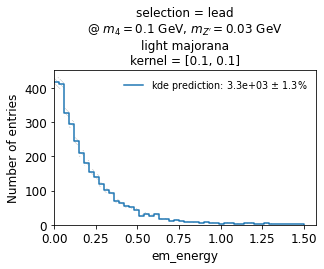

In [9]:
kde_variable_plot(var='em_energy', 
                  range=[0, 1.5], 
                  bins=50, 
                  m4mz=m4mz, 
                  exp_analysis_obj=exp_analysis, 
                  smoothing_pars=smoothing_pars, 
                  selection_query='lead',
                  additional_scaling=mu*0.5)
plt.xlim(left=0)
plt.ylim(bottom=0)

In [25]:
selection = 'carbon'
exp_analysis = my_exp_analyses['light_majorana']
m4mz = (0.2, 0.1)
smoothing_pars = [0.1, 0.1]
mu = 0.25 * 8e-9 / exp_analysis.alpha_dark / exp_analysis.Umu4
mass_ratio = 1848.6 * 1e-9 * 184**2  * 15 / mass_material[selection]

In [36]:
m4_s = np.asarray([0.1, 0.25, 0.42])
mz_s = np.linspace(0.005, 0.195, 20)

In [39]:
m4_mu = {}
m4_sigma2 = {}
for m4 in m4_s:
    m4_mu[m4] = []
    m4_sigma2[m4] = []
    for mz in mz_s:
        kde_weights = exp_analysis.kde_on_a_point(exp_analysis.df_base.query('carbon'),
                                                  this_m4mz=(m4, mz),
                                                  smoothing=smoothing_pars) * mu * mass_ratio
        m4_mu[m4].append(kde_weights.sum())
        m4_sigma2[m4].append((kde_weights**2).sum())

Text(0.5, 1.0, 'BP-L2, carbon only in the FGD\nno selection, 2e20 POT')

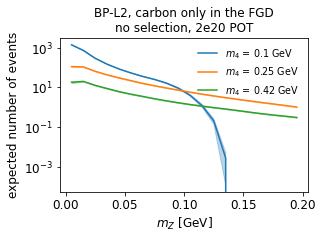

In [41]:
for m4 in m4_s:
    aux_line = plt.plot(mz_s, m4_mu[m4], label=f'$m_4$ = {m4} GeV')
    plt.fill_between(mz_s, m4_mu[m4]-np.sqrt(m4_sigma2[m4]),
                           m4_mu[m4]+np.sqrt(m4_sigma2[m4]),
                    color=aux_line[0].get_color(), alpha=0.3)
    
plt.ylabel('expected number of events')
plt.xlabel('$m_Z$ [GeV]')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('BP-L2, carbon only in the FGD\nno selection, 2e20 POT')

# Event rate in the light case in the last sheet of lead

In [18]:
from parameters_dict import *

In [19]:
selection = 'lead & cut_based'
exp_analysis = my_exp_analyses['light_majorana']
m4mz = (0.1, 0.03)
smoothing_pars = [0.1, 0.1]
mu = 0.25 * 8e-9 / exp_analysis.alpha_dark / exp_analysis.Umu4
mass_ratio = 1/14 * 0.1

In [21]:
selection = 'lead'
mass_ratio = 1/14

(0.0, 64.69992179332084)

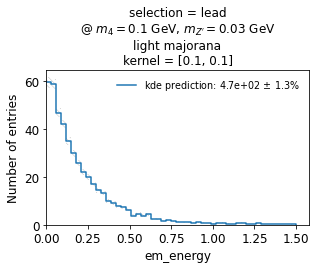

In [22]:
kde_variable_plot(var='em_energy', 
                  range=[0, 1.5], 
                  bins=50, 
                  m4mz=m4mz, 
                  exp_analysis_obj=exp_analysis, 
                  smoothing_pars=smoothing_pars, 
                  selection_query=selection,
                  additional_scaling=mu*mass_ratio)
plt.xlim(left=0)
plt.ylim(bottom=0)

## Event rate vs ee energy for different ctaus

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.pyplot import *
from matplotlib.patches import FancyArrowPatch

In [ ]:
def plot_var_postsel_and_cut(myexp, variable, m4, mz, ctaus, \
                             selection_step='no_cuts', 
                             smooth_m4=0.005, 
                             smooth_mz=0.05, 
                             label_x='x',
                             bins=10,
                             xrange=(0,5),
                             colors=None,
                             left_cut=None,
                             right_cut=None,
                             normed=False):
    
    fsize=11
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
    params={'axes.labelsize':fsize,'xtick.labelsize':fsize,'ytick.labelsize':fsize,\
                'figure.figsize':(1.5*3,1.5*2.4)	}
    rc('font',**{'family':'serif', 'serif': ['computer modern roman']})
    plt.rcParams['hatch.linewidth'] = 0.3
    rcParams.update(params)
    axes_form  = [0.14,0.17,0.82,0.74]
    fig = plt.figure()
    ax = fig.add_axes(axes_form)
        
    m4_values = myexp.df_base['m4'].values
    mz_values = myexp.df_base['mzprime'].values
    
    df_values = np.stack([m4_values, mz_values], axis=-1)
    
    this_kde_weights = myexp.kde_Nd_weights(np.array([m4, mz]), df_values, smoothing=[smooth_m4, smooth_mz])

    myexp.decay_in_tpc(myexp.df_base, ctaus)
    
    for ctau in ctaus:
        weight_values = this_kde_weights *\
                        myexp.df_base['actual_weight'].values *\
                        myexp.df_base[selection_step].values *\
                        myexp.df_base[f'decay_in_tpc_{ctau}'].values

        if colors is not None:
            color=colors[ctaus.index(ctau)]
        else:
            color='black'
            
        out = plt.hist(myexp.df_base[variable], 
                       bins=bins, 
                       range=xrange,
                       weights=weight_values, 
                       label=f"ctau = {ctau} cm, nevt = {weight_values.sum():.0f} $\pm$ {np.sqrt((weight_values**2).sum()):.0f}", 
                       histtype='step',
                       lw=1.5,
                      density=normed,
                      color=color)

    y1, y2 = ax.get_ylim()
    x1, x2 = ax.get_xlim()

    if left_cut is not None:
        leftArrow = FancyArrowPatch(posA=(left_cut-(x2-x1)/15, (y2-y1)*0.8), posB=(left_cut, (y2-y1)*0.8), arrowstyle='<|-',
                          mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(leftArrow)
        ax.axvline(left_cut,c='black')

    if right_cut is not None:
        rightArrow = FancyArrowPatch(posA=(right_cut, (y2-y1)*0.8), posB=(right_cut+(x2-x1)/15, (y2-y1)*0.8), arrowstyle='-|>',
                              mutation_scale=20, shrinkA=0, shrinkB=0, color='black')
        ax.add_artist(rightArrow)
        ax.axvline(right_cut,c='black')

    plt.legend(frameon=False)
    ax.set_xlabel(label_x)
    return fig, ax


In [ ]:
ctaus = [0.1, 1, 10, 100]
colors = ['blue', 'green', 'orange', 'purple', 'red']

m4 = 0.12
mz = 1.25

variable = ('ee_momentum')
selection_step = 'cut_based'
cut=0.150
plot_var_postsel_and_cut(my_exp_analysis, 'ee_energy', m4, mz, ctaus, 
                         selection_step, 
                         smooth_m4=0.05, 
                         smooth_mz=0.1, 
                         left_cut=2.5,
                        colors=colors)
#                         right_cut=0.8)

# Standard HNL comparison

In [ ]:
from fourvec import *

In [ ]:
df_std = pd.read_pickle(f'../standardHNL/data/MC_m4_0.15_mzprime_1.25.pckl')
# compute useful variables
for df in [df_std]:
    for comp in ['t','x','y','z']:
        df['pee', comp] = df['plm', comp] + df['plp', comp]
        df['pdark', comp] = df['plm', comp] + df['plp', comp] + df['pnu', comp]
    df['recoil_mass', ''] = inv_mass(df['pHad']).round(6)
    df['ee_mass', ''] = inv_mass(df['pee'])
    df['ee_costheta', ''] = costheta(df['plm'], df['plp'])
    df['ee_beam_costheta', ''] = df['pee', 'z']/np.sqrt(dot3_df(df['pee'], df['pee']))
    df['ee_momentum', ''] = np.sqrt(dot3_df(df['pee'], df['pee']))
    df['experimental_t', ''] = (df['plm','t'] - df['plm','z'] + df['plp','t'] - df['plp','z'])**2 +\
                                   df['plm','x']**2 + df['plm','y']**2 + df['plp','x']**2 + df['plp','y']**2
    
# weights
wstd=df_std['weight', '']/np.sum(df_std['weight', ''])


In [ ]:
save_dir='../plots/stdHNL/'

In [ ]:
case = 'heavy'
D_or_M = 'majorana'
m4mz=(0.15, 1.25)

my_exp_analysis = exp_analysis(case, D_or_M)
my_exp_analysis.load_df(0.15, 1.25)
no_scan = my_exp_analysis.dfs[m4mz]
selected_df = no_scan.query('cut_based')

In [ ]:
ctau=0.1
my_exp_analysis.decay_in_tpc(no_scan, ctau)
weights_geometric = no_scan[f'decay_in_tpc_{ctau}']

In [ ]:
actual_weights = selected_df['actual_weight']
actual_weights *= weights_geometric

var='ee_momentum'

no_scan_pred, bin_edges = np.histogram(selected_df[var],
                            range=[0,5],
                            bins=10,
                            weights=actual_weights,
                            )
no_scan_pred_err = np.histogram(selected_df[var],
                            range=[0,5],
                            bins=10,
                            weights=actual_weights**2,
                            )[0] 


In [ ]:
EMAX=8.0
bins=8

ctaus = [2, 10]
m4 = 0.15
mz = 1.25
variable = ('ee_momentum')
selection_step = 'cut_based'
cut=0.150
fig, ax = plot_var_postsel_and_cut(my_exp_analysis, 'ee_energy', m4, mz, ctaus, 
                                    selection_step, 
                                    smooth_m4=0.03, 
                                    smooth_mz=0.1, 
                                    right_cut=0.140,
                                    normed=True,
                                    bins=bins,
                                   colors=['red','forestgreen'],
                                    xrange=(0,EMAX))

# now generated prediction
ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2, no_scan_pred, 
            yerr=np.sqrt(no_scan_pred_err),
            fmt='k.',
            label=f'no scanning: {no_scan_pred.sum():.2g} '\
            f'$\pm$ {100*np.sqrt(no_scan_pred_err.sum())/no_scan_pred.sum():.2g}%')

out = ax.hist(df_std['ee_momentum', ''], 
               bins=bins, 
               range=(0, EMAX),
               weights=wstd, 
               label='standard decay-in-flight HNL',
                facecolor='None',
              edgecolor='royalblue',
              lw=0.5,
               histtype='bar',
            hatch='////',
             density=True)


out = ax.hist(df_std['ee_momentum', ''], 
               bins=bins, 
               range=(0, EMAX),
               weights=wstd, 
                facecolor='None',
              edgecolor='royalblue',
              lw=1.0,
               histtype='bar',
             density=True)

ax.legend(loc='upper right',frameon=False)
ax.set_xlabel(r"$|\vec{p}_{e^+e^-}|$ (GeV)")
ax.set_ylabel(r"a.u.")
ax.set_xlim(0.,EMAX)
ax.set_title(r"$m_4 = 150$ MeV -- all inclusive",fontsize=fsize)
plt.savefig(f"{save_dir}/ee_momentum.png", dpi=400)